# Exploratory Data Analysis

## TODO

- Incorporate region info for:
    - Perhaps conditional activation: weight by number of regions that the NPI is active in
- Timeline plots.

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="ticks", color_codes=True)
import pylab as pl


df = pd.read_csv('../data/all_merged_data.csv')
CMs = df.columns[5:]

## NPI representation: total, by country, by region

<BarContainer object of 20 artists>

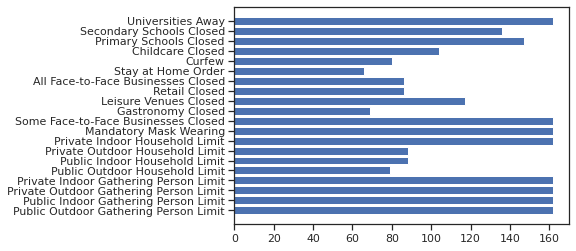

In [6]:
def count_active_days(npi):
    non_zero_rows = [ind for ind in range(df.shape[0]) if df[npi][ind] != 0]
    return len(np.unique(df['Date'][non_zero_rows]))
active_days = [count_active_days(npi) for npi in CMs]
plt.barh(y=CMs, width=active_days, title='Number of days that each NPI is active in any region of any country')

8 of the NPIs are always active in our window.

<AxesSubplot:title={'center':'Number of days that each NPI is active in any region of any country'}, xlabel='CMs'>

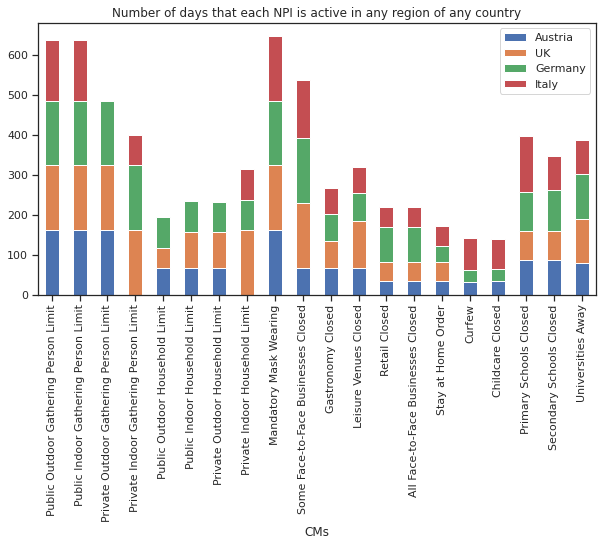

In [19]:
def count_active_days_country(npi):
    non_zero_rows = [ind for ind in range(df.shape[0]) if df[npi][ind] != 0]
    active_inds = []
    for country in np.unique(df['Country']):
        active_ind = [ind for ind in non_zero_rows if df['Country'][ind] == country]
        count = len(np.unique(df['Date'][active_ind]))
        active_inds.append(count)
    return active_inds
active_days_country = [count_active_days_country(npi) for npi in CMs]
active_days_country = pd.DataFrame((active_days_country))
active_days_country.columns = ['Austria', 'UK', 'Germany', 'Italy']
active_days_country['CMs'] = CMs
active_days_country.set_index('CMs').plot(kind='bar', stacked=True, title='Number of days each NPI is active in any region of each specific country', figsize = (10,5))

Only 3 of the NPIs are always active in each country.


In [8]:
def count_active_days_region(npi, country):
    df_country = df[df['Country']==country]
    #non_zero_rows = [ind for ind in range(df_country.shape[0]) if df_country[npi][ind] != 0]
    non_zero_rows = df_country[df_country[npi] != 0]
    regions = np.unique(df_country['Area'])
    active_inds = []
    for region in regions:
        #active_ind = [ind for ind in non_zero_rows if df_country['Area'][ind] == region]
        #active_ind = df_country.loc[df_country['Area'] == region]
        active_rows = non_zero_rows[non_zero_rows['Area']==region]
        count = active_rows.shape[0]
        active_inds.append(count)
    return regions, active_inds

active_days_uk = [count_active_days_region(npi, 'England')[1] for npi in CMs]
active_days_de = [count_active_days_region(npi, 'Germany')[1] for npi in CMs]
active_days_at = [count_active_days_region(npi, 'Austria')[1] for npi in CMs]
active_days_it = [count_active_days_region(npi, 'Italy')[1] for npi in CMs]

# summing up counts from the regions for each npi:
region_counts_uk = [sum(i) for i in active_days_uk]
region_counts_de = [sum(i) for i in active_days_de]
region_counts_at = [sum(i) for i in active_days_at]
region_counts_it = [sum(i) for i in active_days_it]

<AxesSubplot:title={'center':"Coloured bar length is the sum of days across the country's regions that the NPI is active"}, xlabel='CMs'>

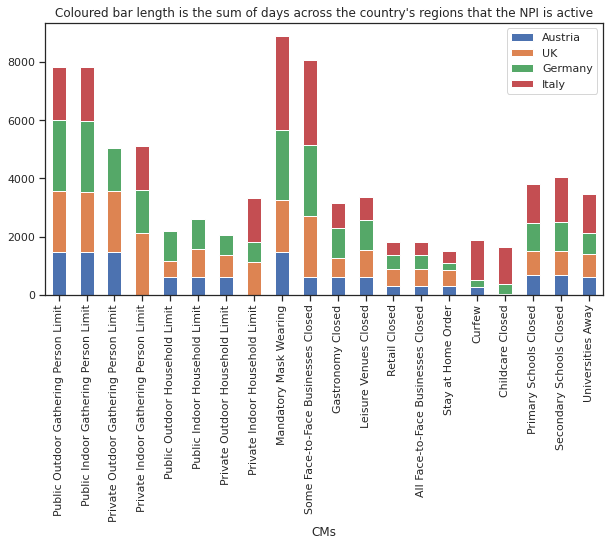

In [20]:
region_counts = pd.DataFrame((CMs, region_counts_at, region_counts_uk,
region_counts_de, region_counts_it)).T
region_counts.columns = ['CMs', 'Austria', 'UK', 'Germany', 'Italy']
region_counts.set_index('CMs').plot(kind='bar', stacked=True, title='Coloured bar length is the sum of days across the country\'s regions that the NPI is active', figsize = (10,5))

 I plotted this because plot 2 doesn't distinguish between worlds where only one region in a country is active at a time vs all the regions in a country is active at that time.

In [10]:
len(np.unique(df['Area']))
#total number of days:
162*len(np.unique(df['Area']))

9558

4 NPIs are active for most of the region-days. Mandatory mask wearing approaches, but does not reach
, the maximum possible number of region-days. 5 NPIs are active for around half of the possible
 region-days. Half of the NPIs are active for around 1/4 of the total possible region-days.

The split of colour for each NPI is quite similar to the country-level split. This indicates that region-NPI-activation
is relatively constant across country for each NPI. Exceptions include 'Curfew' and 'Childcare closed',
for which Italy has a much larger share at the region-level versus the country-level.

Relative height is also very similar, indicating (I think) similar proportional region activation for each NPI.
Exceptions include Primary schools, Secondary school, and University closures, which
are relatively smaller on the region-level.

## Thresholding

Text(0.5, 0.98, 'Histogram of values (thresholds) for the relevant NPIs (includes 0 as a value)')

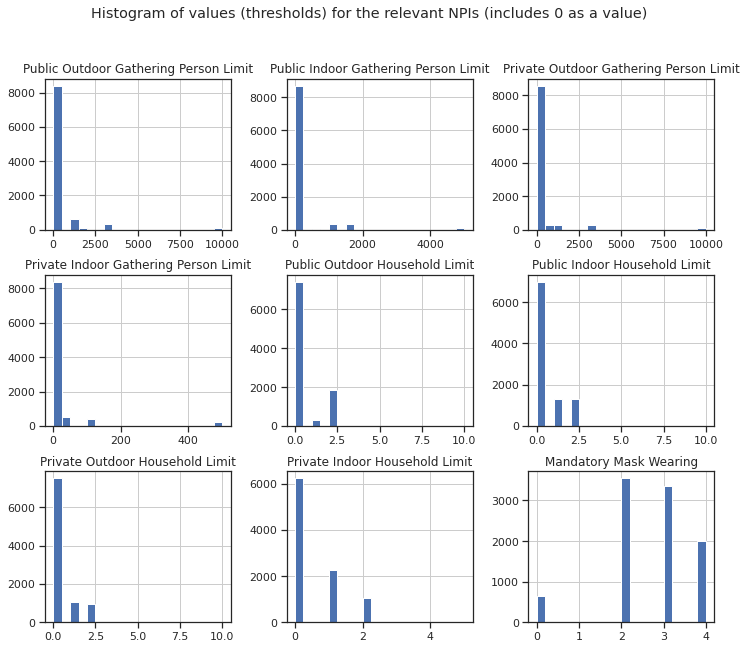

In [11]:
thresholding_CMs = [CM for CM in CMs if len(np.unique(df[CM]))>2]
#dataframe with only thresholidng npis
df.hist(column=thresholding_CMs, figsize=(12, 10), bins=20)
pl.suptitle("Histogram of values (thresholds) for the relevant NPIs (includes 0 as a value)")

Text(0.5, 0.98, 'Histogram of values (thresholds) for the relevant NPIs (excludes 0 as a value)')

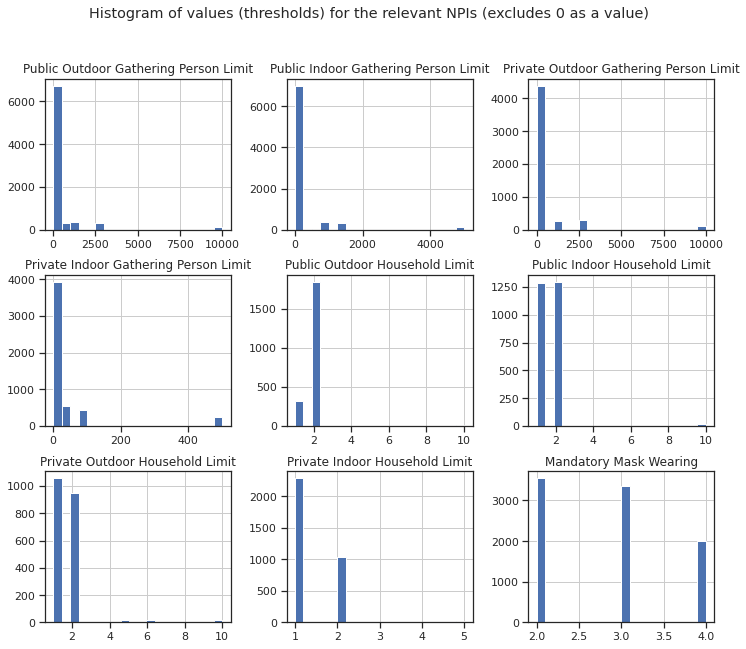

In [23]:
df_reduced = df[df!=0]
df_reduced.hist(column=thresholding_CMs, figsize=(12, 10), bins = 20)
pl.suptitle("Histogram of values (thresholds) for the relevant NPIs (excludes 0 as a value)")
#TODO: consider weighting by active days

In [29]:
df_reduced = df[df!=0]
df_numbers = df[isinstance(df, float)]
#find ind of all
# ax = df.hist(column=thresholding_CMs, figsize=(12, 10), bins = 20)
# pl.suptitle("Histogram of values (thresholds) for the relevant NPIs (excludes 0 as a value)")

KeyError: False

## Conditional activation

In [16]:
def get_active_dates(npi):
    non_zero_dates = df['Date'][df[npi] != 0]
    return np.unique(non_zero_dates)

def intersect_npi_active_dates(npi_1, npi_2):
    return set(get_active_dates(npi_1)).intersection(set(get_active_dates(npi_2)))

def get_inactive_dates(npi):
    zero_dates = df['Date'][df[npi] == 0]
    return np.unique(zero_dates)

def proportional_activation(npi_1, npi_2):
    number_of_active_days = len(get_active_dates(npi_1))
    number_of_jointly_active_days = len(intersect_npi_active_dates(npi_1, npi_2))
    return number_of_jointly_active_days/number_of_active_days

def activation_difference(npi_1, npi_2):
    return len(set(get_active_dates(npi_1)) - set(get_active_dates(npi_2)))

def only_one_active(npi_1, npi_2):
    return len(set(get_active_dates(npi_1)) - set(get_active_dates(npi_2))) + len(set(get_active_dates(npi_2)) - set(get_active_dates(npi_1)))

proportional_activations = np.zeros((len(CMs),len(CMs)))
activation_differences = np.zeros((len(CMs),len(CMs)))
single_activations = np.zeros((len(CMs),len(CMs)))
for i in range(len(CMs)):
    for j in range(len(CMs)):
        proportional_activations[i, j] = proportional_activation(CMs[i], CMs[j])
        activation_differences[i, j] = activation_difference(CMs[i], CMs[j])
        single_activations[i, j] = only_one_active(CMs[i], CMs[j])

Text(0.5, 1.0, 'Conditional activation matrix: of the proportion of time that NPI Y was active, how often was NPI X active?')

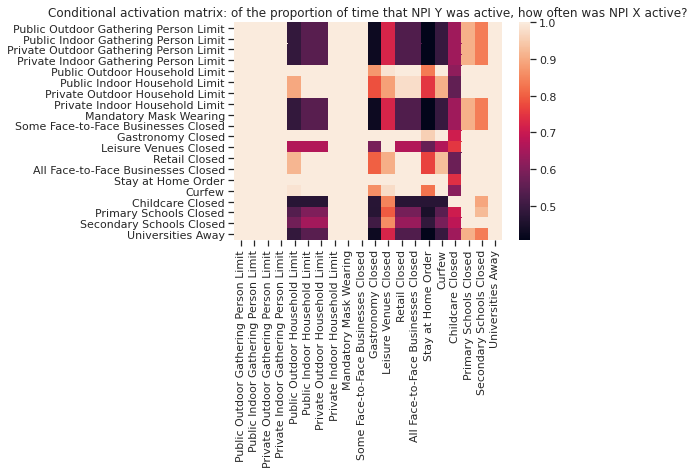

In [30]:
sns.heatmap(proportional_activations, xticklabels = CMs, yticklabels = CMs).set_title('Conditional activation matrix: of the proportion of time that NPI Y was active, how often was NPI X active?')
# sns.set(rc={'figure.figsize':(11.7,10.27)})

Text(0.5, 1.0, 'Number of days where only NPI Y is active')

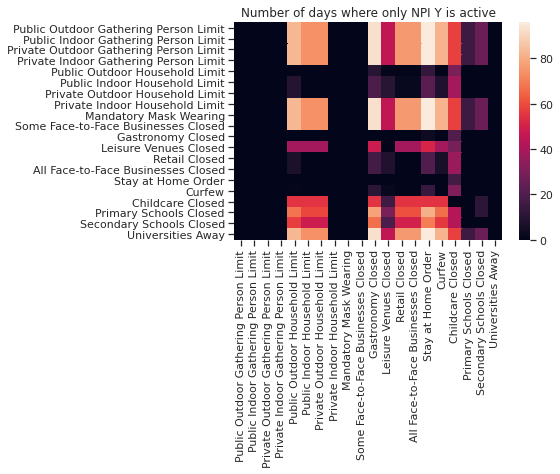

In [31]:
sns.heatmap(activation_differences, xticklabels = CMs, yticklabels = CMs).set_title('Number of days where only NPI Y is active')
# sns(rc={'figure.figsize':(11.7,10.27)})

Text(0.5, 1.0, 'Number of days where exactly one of NPI X and NPI Y is active')

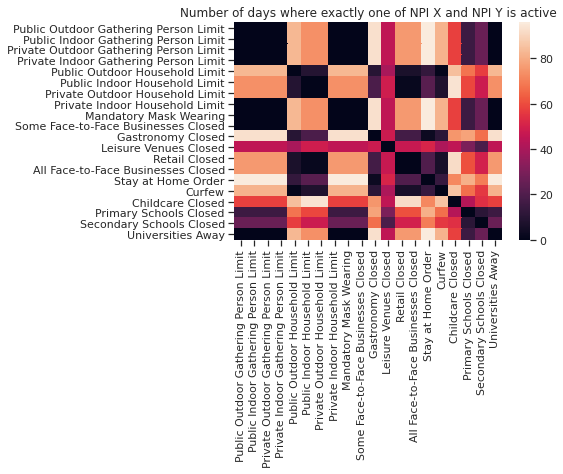

In [32]:
sns.heatmap(single_activations, xticklabels = CMs, yticklabels = CMs).set_title('Number of days where exactly one of NPI X and NPI Y is active')
# sns(rc={'figure.figsize':(11.7,10.27)})

## Timeline plots

In [ ]:


def add_cms_to_plot(ax, ActiveCMs, country_indx, min_x, max_x, days, plot_style, plot_reopenings=True):
    """
    Plotter helper.
    This takes a plot and adds NPI logos on them.
    :param ax: axis to draw
    :param ActiveCMs: Standard ActiveCMs numpy array
    :param country_indx: Country to pull CM data from
    :param min_x: x limit - left
    :param max_x: x limit - right
    :param days: days to plot
    :param plot_style: NPI Plot style
    """
    ax2 = ax.twinx()
    plt.ylim([0, 1])
    plt.xlim([min_x, max_x])
    CMs = ActiveCMs[country_indx, :, :]
    nCMs, _ = CMs.shape
    CM_changes = np.zeros((nCMs, len(days)))
    CM_changes[:, 1:] = CMs[:, 1:] - CMs[:, :-1]
    all_CM_changes = np.sum(CM_changes, axis=0)
    all_heights = np.zeros(all_CM_changes.shape)
    for cm in range(nCMs):
        changes = np.nonzero(CM_changes[cm, :])[0].tolist()
        height = 1
        for c in changes:
            close_heights = all_heights[c - 3:c + 4]
            if len(close_heights) == 7:
                height = np.max(close_heights) + 1
                all_heights[c] = height
            plt.plot(
                [c, c],
                [0, 1],
                "--",
                color="lightgrey",
                linewidth=1,
                zorder=-2,
                alpha=0.5
            )
            plot_height = 1 - (0.04 * height)
            if c < min_x:
                c_p = min_x
            else:
                c_p = c
            if CM_changes[cm, c] == 1:
                plt.text(c_p, plot_height, plot_style[cm][0], fontproperties=fp2, color=plot_style[cm][1], size=8,
                         va='center', ha='center', clip_on=True, zorder=1)
            elif plot_reopenings:
                plt.text(c_p, plot_height, plot_style[cm][0], fontproperties=fp2, color=plot_style[cm][1], size=8,
                         va='center', ha='center', clip_on=True, zorder=1)
                plt.plot([c_p - 1.5, c + 1.5], [plot_height - 0.005, plot_height + 0.005], color="black", zorder=2)
    plt.yticks([])
    return ax2